## Import Libraries, load and show sample of data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


In [2]:
train_link = "/kaggle/input/playground-series-s5e6/train.csv"
test_link = "/kaggle/input/playground-series-s5e6/test.csv"

In [3]:
train_df = pd.read_csv(train_link, index_col=0)
test_df = pd.read_csv(test_link, index_col=0)

In [4]:
train_df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


## Variables split

In [5]:
target_name = "Fertilizer Name"
categorical_variables = list(train_df.dtypes[( train_df.dtypes=="object" ) & ( train_df.columns != target_name )].index)
numeric_variables = list(train_df.dtypes[train_df.dtypes=="int"].index)

possible_targets = train_df[target_name].unique()

## EDA

### randomly select subset of data to perform initial EDA to make it quicker

In [6]:
np.random.seed(42)
random_selection = np.random.choice(range(len(train_df)), size=10**5)

In [7]:
nan_counts = train_df.isna().sum()
nan_counts

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

In [8]:
train_df.describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [9]:
train_df.nunique()

Temparature        14
Humidity           23
Moisture           41
Soil Type           5
Crop Type          11
Nitrogen           39
Potassium          20
Phosphorous        43
Fertilizer Name     7
dtype: int64

## Plots

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


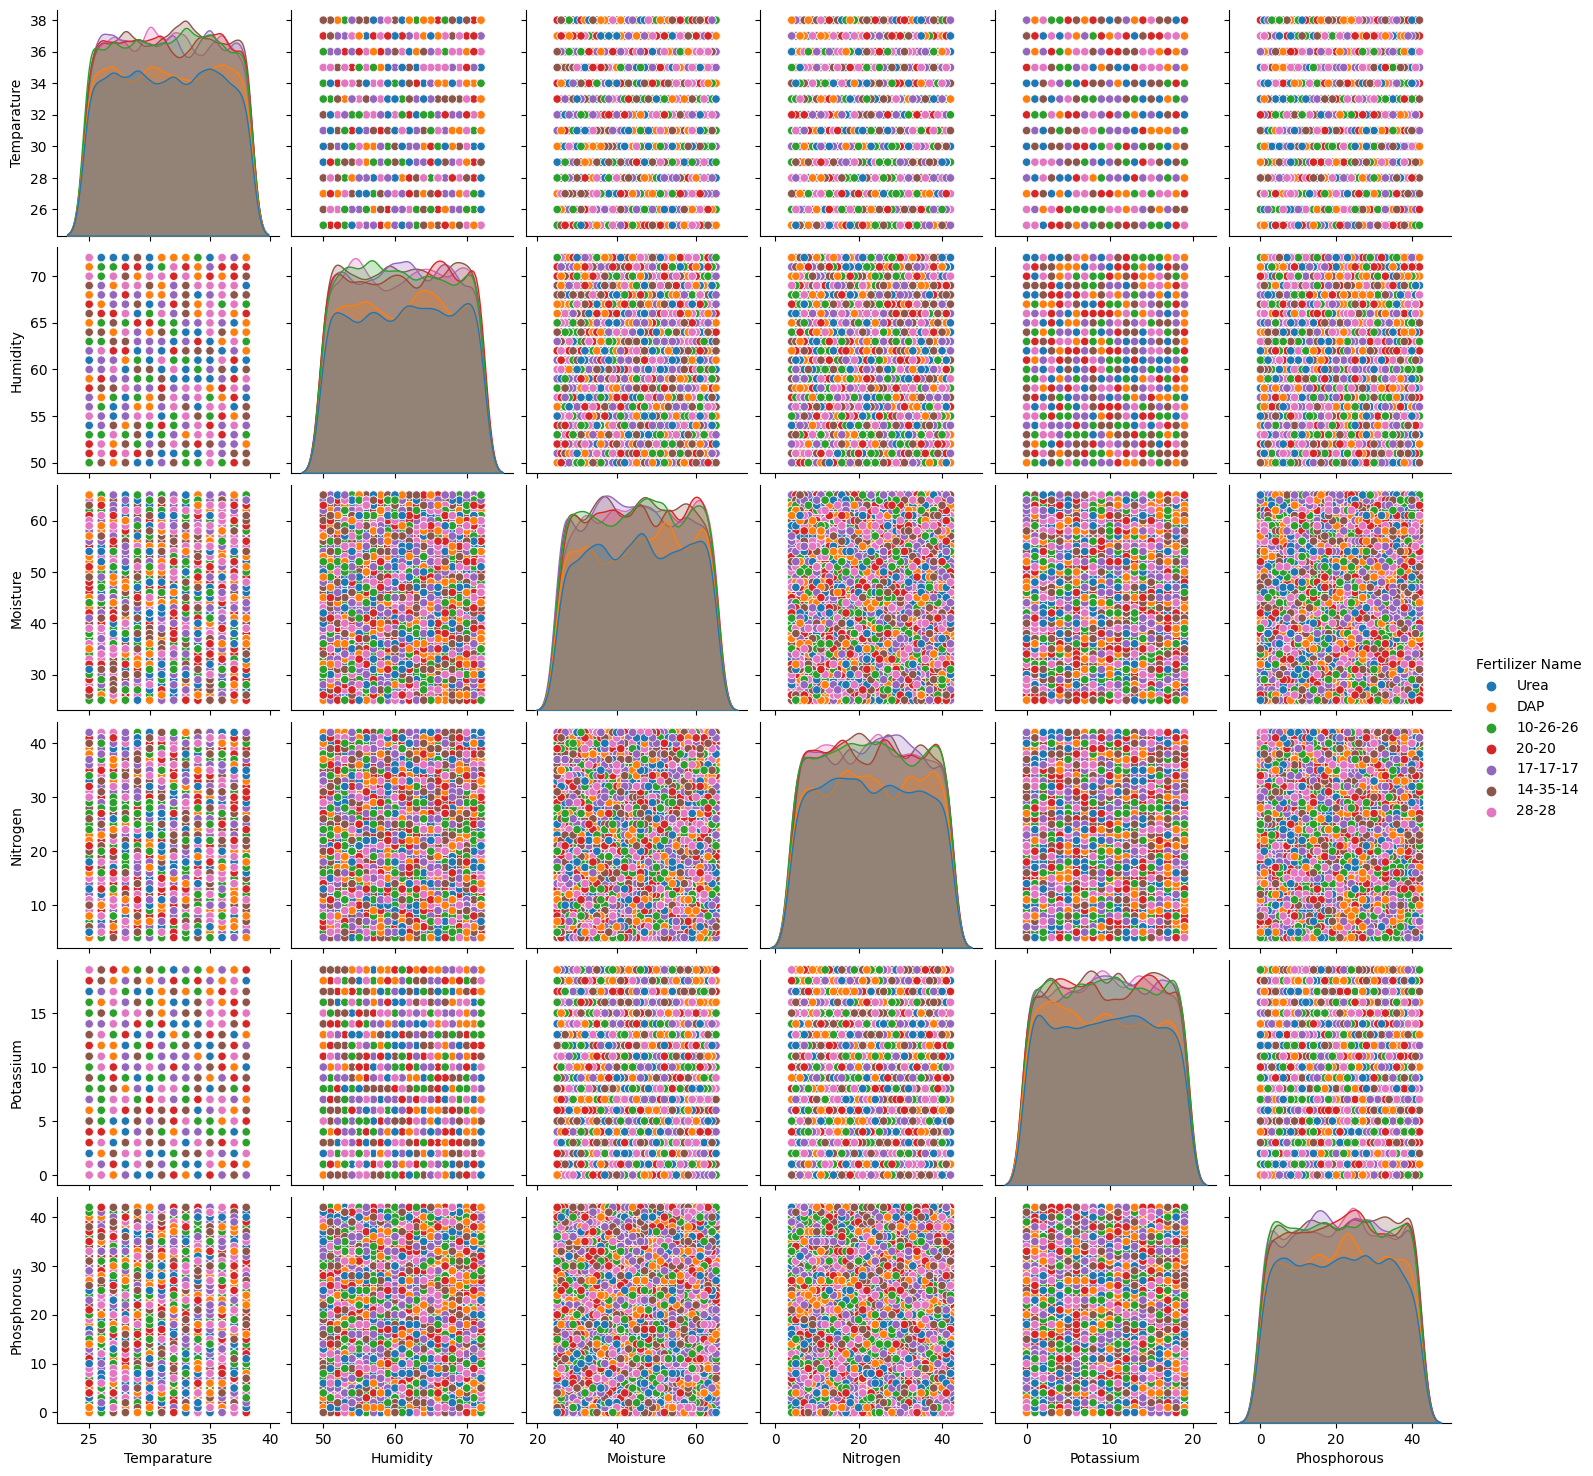

In [11]:
sns.pairplot(train_df.iloc[random_selection], kind="scatter", diag_kind="kde", hue=target_name)

<Axes: >

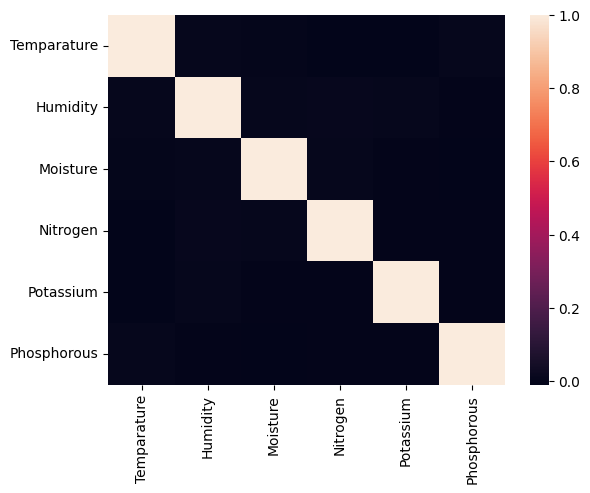

In [12]:
sns.heatmap(train_df.iloc[random_selection][numeric_variables].corr())

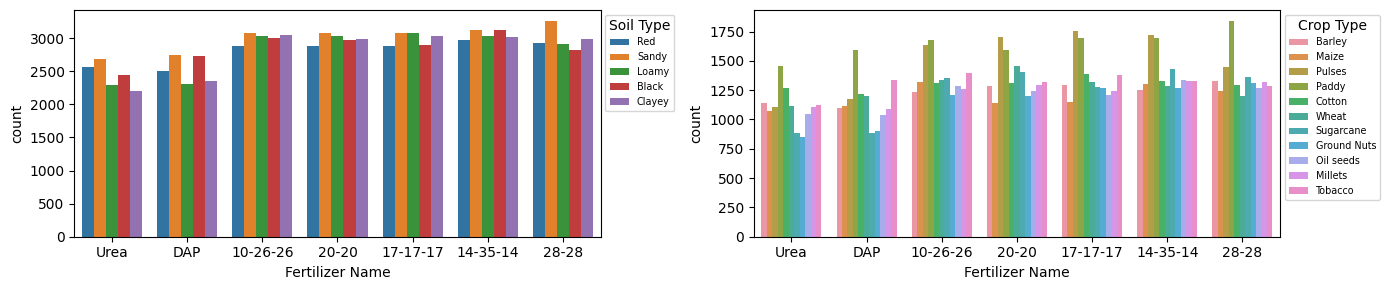

In [13]:
fig, axes = plt.subplots(1, len(categorical_variables), figsize=(14, 3))
for i, var_name in enumerate(categorical_variables):
    sns.countplot(data=train_df.iloc[random_selection], hue=var_name, x=target_name, ax=axes[i])
    axes[i].legend(title=var_name, loc='best', fontsize="x-small", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

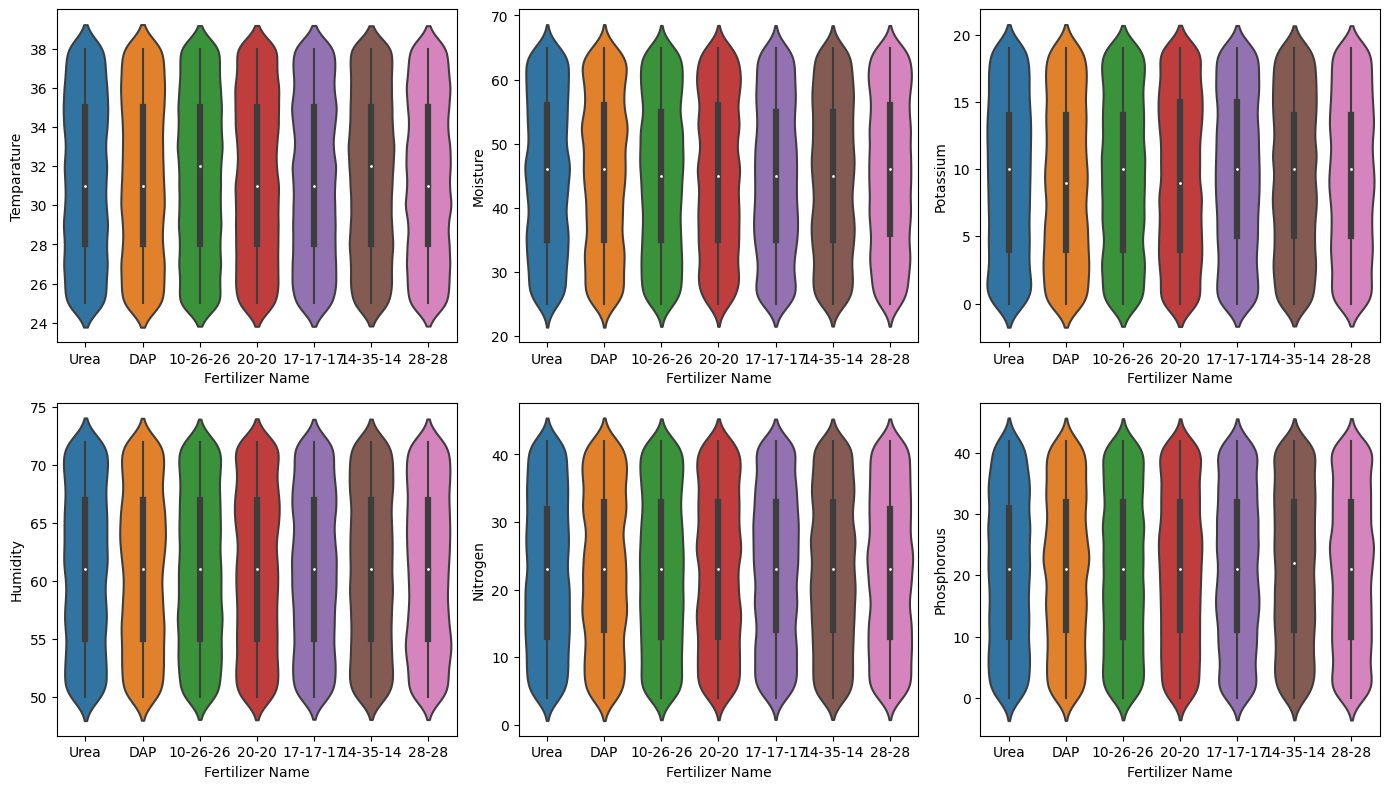

In [14]:
fig, axes = plt.subplots(2, len(numeric_variables)//2, figsize=(14, 8))
for i, var_name in enumerate(numeric_variables):
    sns.violinplot(data=train_df.iloc[random_selection], x=target_name, y=var_name, ax=axes[i%2, i//2])

plt.tight_layout()
plt.show()

## Importance of variables based on simple decision tree

In [15]:
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

### but first simple preprocessing pipeline

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_variables),
        ('num', 'passthrough', numeric_variables)
    ])

# Create pipeline: preprocessing + decision tree
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, min_samples_leaf=0.05))
])

In [17]:
X = train_df[categorical_variables + numeric_variables]# .iloc[random_selection]
y = train_df[target_name]# .iloc[random_selection]

In [18]:
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['Soil Type', 'Crop Type']),
                                                 ('num', 'passthrough',
                                                  ['Temparature', 'Humidity',
                                                   'Moisture', 'Nitrogen',
                                                   'Potassium',
                                                   'Phosphorous'])])),
                ('classifier',
                 DecisionTreeClassifier(min_samples_leaf=0.05,
                                        random_state=42))])

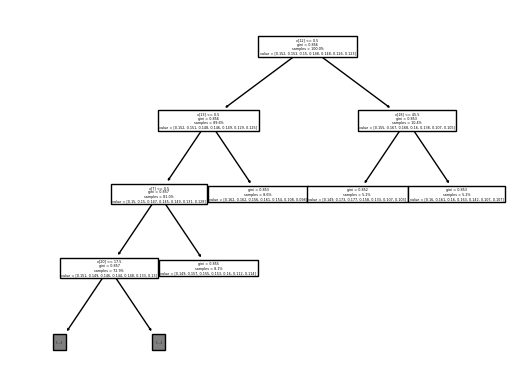

In [19]:
tree.plot_tree(clf["classifier"], max_depth=3, proportion=True)
plt.show()

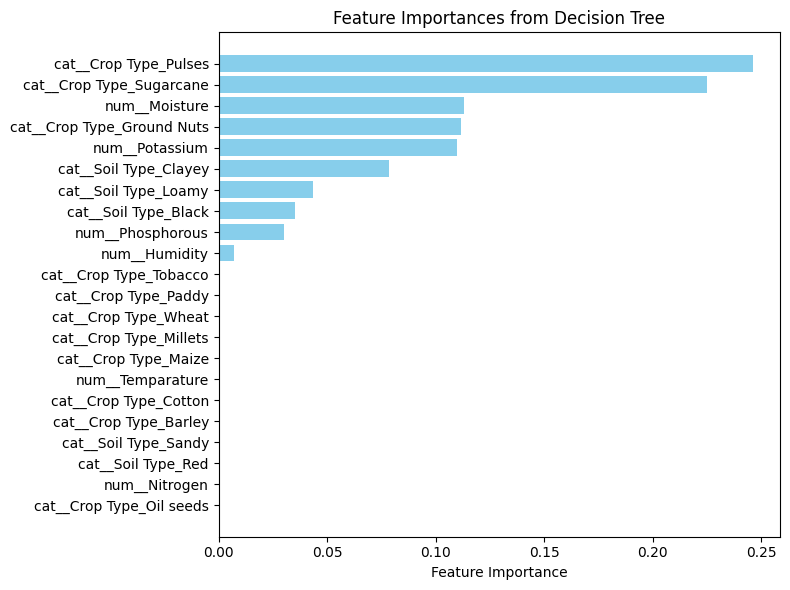

In [20]:
feat_imp = pd.DataFrame({'feature': clf["preprocessor"].get_feature_names_out(), 'importance': clf["classifier"].feature_importances_})
feat_imp = feat_imp.sort_values(by='importance', ascending=True)  # Sort for better visualization

plt.figure(figsize=(8, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Decision Tree')
plt.tight_layout()
plt.show()

## GLM build

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_variables),
        ('num', StandardScaler(), numeric_variables)
    ])

# Create pipeline: preprocessing + decision tree
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression()) # OneVsRestClassifier(LogisticRegression())
])

In [22]:
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Soil Type', 'Crop Type']),
                                                 ('num', StandardScaler(),
                                                  ['Temparature', 'Humidity',
                                                   'Moisture', 'Nitrogen',
                                                   'Potassium',
                                                   'Phosphorous'])])),
                ('classifier', LogisticRegression())])

In [23]:
clf["classifier"].coef_.shape

(7, 20)

In [24]:
from sklearn.metrics import average_precision_score
for fertilizer_name in possible_targets:
    print(average_precision_score(
        y == fertilizer_name,
        clf.predict(X) == fertilizer_name
    )
         )

0.15063384734662527
0.15241907674596633
0.15379808834471273
0.12758194899990105
0.14860664424806114
0.15498056952246603
0.123102353277631


## Submission

In [25]:
y_test = clf.predict(test_df)
y_test[:5]

array(['20-20', '10-26-26', '17-17-17', '14-35-14', '17-17-17'],
      dtype=object)

In [26]:
submission_df = pd.DataFrame(
    {
        "id": test_df.index,
        "Fertilizer Name": y_test
    }
)
submission_df.head()

,id,Fertilizer Name
0,750000,20-20
1,750001,10-26-26
2,750002,17-17-17
3,750003,14-35-14
4,750004,17-17-17


In [27]:
submission_df.to_csv("LogisticRegressionSubmission.csv", index=False)